# Import libraries

In [1]:
%%capture
%pip install mne
%pip install ipympl
%pip install EMD-signal
%pip install -U imbalanced-learn

# Instell this if you are using jupyter lab
# conda install -c conda-forge nodejs
# jupyter labextension install @jupyter-widgets/jupyterlab-manager
# jupyter lab build

In [2]:
# Import libraries

import os
import sys
import joblib
import re
import glob
from os.path import dirname, join as pjoin

import pandas as pd
import numpy as np

# from google.colab import drive

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score, silhouette_samples, silhouette_score

from imblearn.over_sampling import SMOTE, RandomOverSampler, BorderlineSMOTE, SVMSMOTE

from tabulate import tabulate

# from __future__ import annotations

from sklearn.svm import SVC

# from scipy import signal
from scipy.stats import entropy, skew, kurtosis
from scipy.signal import butter, filtfilt
from scipy.io import loadmat
from scipy.signal import welch
from scipy.signal import stft
from scipy.signal import resample # Resample signal
from scipy.signal import firwin, lfilter
from scipy.signal import hilbert, periodogram, spectrogram

import nolds
from PyEMD import EMD

import matplotlib.pyplot as plt
import seaborn as sns

import neurokit2 as nk

import mne
import yasa

import warnings
warnings.filterwarnings("ignore")

# Format Data

In [3]:
filenames, excerpts, visuals, hypnograms, automatic = [], [], [], [], []

for name in glob.glob('data/*excerpt*.txt'):
    # print(os.path.split(name)[1])

    filename = os.path.split(name)[1]
    filenames.append(filename)

    if 'Hypnogram' in filename:
      hypnograms.append(filename)
    elif 'Visual' in filename:
      visuals.append(filename)
    elif 'Automatic' in filename:
      automatic.append(filename)
    else:
      excerpts.append(filename)
      

In [4]:
# Import excerpts data
# df_excerpt = pd.concat([pd.read_csv('data/'+filename) for i, filename in enumerate(excerpts)], axis=1)
excerpt_sig_txt = [pd.read_csv('data/'+filename).values for i, filename in enumerate(excerpts)]

In [5]:
# Import Visual_scoringN_excerptN data

visual_data = []
for name in visuals:
    data = pd.read_csv('data/' + name, sep='\s+', names=['Spindles', 'C'])
    # print(data.head())
    # print(data.iloc[0][0].replace('[', '').replace(']', '').split('/'))
    col_names = data.iloc[0][0].replace('[', '').replace(']', '').split('/')
    data = data.drop(0)

    # rename multiple columns
    data = data.rename(columns={'Spindles': col_names[0], 'C': col_names[1]})

    data = data.apply(pd.to_numeric)

    visual_data.append(data)

df_visual = pd.concat(visual_data, axis=1)
df_visual.head()

,vis1_Spindles,C3-A1,vis1_Spindles,CZ-A1,vis1_Spindles,C3-A1,vis1_Spindles,CZ-A1,vis1_Spindles,CZ-A1,...,vis2_Spindles,CZ-A1,vis2_Spindles,C3-A1,vis2_Spindles,CZ-A1,vis2_Spindles,CZ-A1,vis2_Spindles,CZ-A1
1,282.24,0.72,0.80,0.80,500.22,1.07,22.02,1.15,13.67,0.87,...,0.725,1.0,297.86,1.0,217.54,1.0,13.590,1.0,6.295,1.0
2,311.72,1.54,6.96,1.26,891.87,1.46,26.02,1.48,20.09,0.50,...,7.150,1.0,387.94,1.0,473.54,1.0,19.905,1.0,31.625,1.0
3,340.28,0.72,22.98,0.85,945.00,0.70,29.89,0.78,30.80,1.28,...,14.825,1.0,500.28,1.0,629.20,1.0,30.845,1.0,84.670,1.0
4,366.83,0.65,26.09,1.28,975.04,0.76,36.52,0.63,33.17,0.59,...,26.120,1.0,509.62,1.0,653.01,1.0,32.950,1.0,94.090,1.0
5,373.74,0.50,31.50,0.74,986.24,0.61,41.41,0.91,36.74,0.52,...,31.515,1.0,511.62,1.0,751.28,1.0,36.445,1.0,131.980,1.0


In [6]:
# Import automatic_detection data

automatic_data = []
for name in automatic:
    data = pd.read_csv('data/' + name, sep='\s+', names=['Spindles', 'C'])
    # print(data.head())
    # print(data.iloc[0][0].replace('[', '').replace(']', '').split('/'))
    col_names = data.iloc[0][0].replace('[', '').replace(']', '').split('/')
    data = data.drop(0)

    # rename multiple columns
    data = data.rename(columns={'Spindles': col_names[0], 'C': col_names[1]})

    automatic_data.append(data)

df_automatic = pd.concat(visual_data, axis=1)
df_automatic.head()

,vis1_Spindles,C3-A1,vis1_Spindles,CZ-A1,vis1_Spindles,C3-A1,vis1_Spindles,CZ-A1,vis1_Spindles,CZ-A1,...,vis2_Spindles,CZ-A1,vis2_Spindles,C3-A1,vis2_Spindles,CZ-A1,vis2_Spindles,CZ-A1,vis2_Spindles,CZ-A1
1,282.24,0.72,0.80,0.80,500.22,1.07,22.02,1.15,13.67,0.87,...,0.725,1.0,297.86,1.0,217.54,1.0,13.590,1.0,6.295,1.0
2,311.72,1.54,6.96,1.26,891.87,1.46,26.02,1.48,20.09,0.50,...,7.150,1.0,387.94,1.0,473.54,1.0,19.905,1.0,31.625,1.0
3,340.28,0.72,22.98,0.85,945.00,0.70,29.89,0.78,30.80,1.28,...,14.825,1.0,500.28,1.0,629.20,1.0,30.845,1.0,84.670,1.0
4,366.83,0.65,26.09,1.28,975.04,0.76,36.52,0.63,33.17,0.59,...,26.120,1.0,509.62,1.0,653.01,1.0,32.950,1.0,94.090,1.0
5,373.74,0.50,31.50,0.74,986.24,0.61,41.41,0.91,36.74,0.52,...,31.515,1.0,511.62,1.0,751.28,1.0,36.445,1.0,131.980,1.0


In [7]:
# Import hypnograms data
df_hypnograms = pd.concat([pd.read_csv('data/'+filename, names=[f'excerpt_{i+1}']) for i, filename in enumerate(hypnograms)], axis=1)
df_hypnograms = df_hypnograms.drop(0)
df_hypnograms.head()

,excerpt_1,excerpt_2,excerpt_3,excerpt_4,excerpt_5,excerpt_6,excerpt_7,excerpt_8
1,5,2,3,5,2,2,1,5
2,5,2,3,5,2,2,1,5
3,5,2,3,5,2,2,1,5
4,5,2,3,5,2,2,1,5
5,5,2,3,5,2,0,2,5


# Preprocessing

In [8]:
%%capture

files_edf = [filename for filename in glob.glob('data\excerpt*.edf')]
excerpt_signals = [0]
raws = [0]

for i, filename in enumerate(files_edf):
    if i == 0:
        continue

    # Load whole night PSG sleep data (EEG, EOG, EMG and EKG signals)
    raw = mne.io.read_raw_edf(filename, preload=True)

    # Check the sampling frequency of the data in Hertz (Hz):
    print(f'Original fs: {raw.info["sfreq"]} Hz')

    # Resampling the data to 200 Hz:
    raw.resample(200)
    sf = raw.info['sfreq']

    print(f'\nNew sampling frequency: {raw.info["sfreq"]} Hz')

    # Store the data before filtering in data 
    data = raw.get_data(units="uV")

    # Filter the EEG signals with an appropriate band pass FIR filter
    # (taking into account that in our sleep analysis the frequencies of interest are between 0.3Hz and 45Hz) 
    # let's apply a 0.3-35 Hz bandpass-filter:
    raw.filter(0.3, 35)

    data_filtered = raw.get_data(units="uV")
    print(data_filtered.shape)

    # excerpt_filtered.append(data_filtered)
    raws.append(raw)


    # The channel we keep is CZ-A1 but for the excerpt 3 we have to use C3-A1 since CZ-A1 is not available
    df = raw.to_data_frame()
    if 'CZ-A1' in df.columns:
        excerpt_signals.append(df['CZ-A1'].values)
    else:
        excerpt_signals.append(df['C3-A1'].values)

# Note for the sampling frequencies:
# 1 - 100
# 2 - 100 (200 in txt)
# 3 - 50
# 4 - 200
# 5 - 200
# 6 - 200
# 7 - 200
# 8 - 200

In [9]:
# We keep the first three signals coming from the txt files and the rest from the edf files
excerpt_signals[0] = np.squeeze(excerpt_sig_txt[0])
excerpt_signals[1] = np.squeeze(excerpt_sig_txt[1])
excerpt_signals[2] = np.squeeze(excerpt_sig_txt[2])

In [10]:
def resample_signal(sig, fs, fs_res):
    n_samps = sig.shape[0]            # Number of samples in signal
    n_samps_res = int(n_samps/fs*fs_res) # Number of samples in signal after resampling
    signal_res = resample(sig, n_samps_res)
    signal_res = np.squeeze(signal_res)
    return signal_res

# Resampling
fs = 200

excerpt_signals[0] = resample_signal(excerpt_signals[0], 100, fs)
# excerpt_signals[1] = resample_signal(excerpt_signals[1], 100, fs)
excerpt_signals[2] = resample_signal(excerpt_signals[2], 50, fs)


In [11]:
def filter_signal(signal_res, lowcut, highcut, fs, numtaps):
    filter_coef = firwin(numtaps, [lowcut, highcut], fs=fs, pass_zero=False)
    filtered_signal = lfilter(filter_coef, 1, signal_res)
    return filtered_signal

# Define the filter specifications
lowcut = 0.3 # Lower cutoff frequency in Hz
highcut = 35 # Upper cutoff frequency in Hz
fs = 200 # New sampling frequency after resampling in Hz
numtaps = 1001 # Number of taps for the filter kernel

excerpt_signals[0] = filter_signal(excerpt_signals[0], lowcut, highcut, fs, numtaps)
excerpt_signals[1] = filter_signal(excerpt_signals[1], lowcut, highcut, fs, numtaps)
excerpt_signals[2] = filter_signal(excerpt_signals[2], lowcut, highcut, fs, numtaps)

for e in excerpt_signals:
    print(e.shape)


(360000,)
(360000,)
(360000,)
(360000,)
(360000,)
(360000,)
(360000,)
(360000,)


In [12]:
excerpt_signals = np.vstack(excerpt_signals)

In [13]:
excerpt_signals.shape

(8, 360000)

In [14]:
# data = excerpt_signals[7]

# # Create the boxplot
# fig, ax = plt.subplots()
# ax.boxplot(data)

# # Add labels and a title
# ax.set_xlabel('Data')
# ax.set_ylabel('Value')
# ax.set_title('Boxplot of Data')

# # Show the plot
# plt.show()

In [15]:
# for i in range(3,8):
#     excerpt_signals[i] = excerpt_signals[i] * 1000000

# EDA

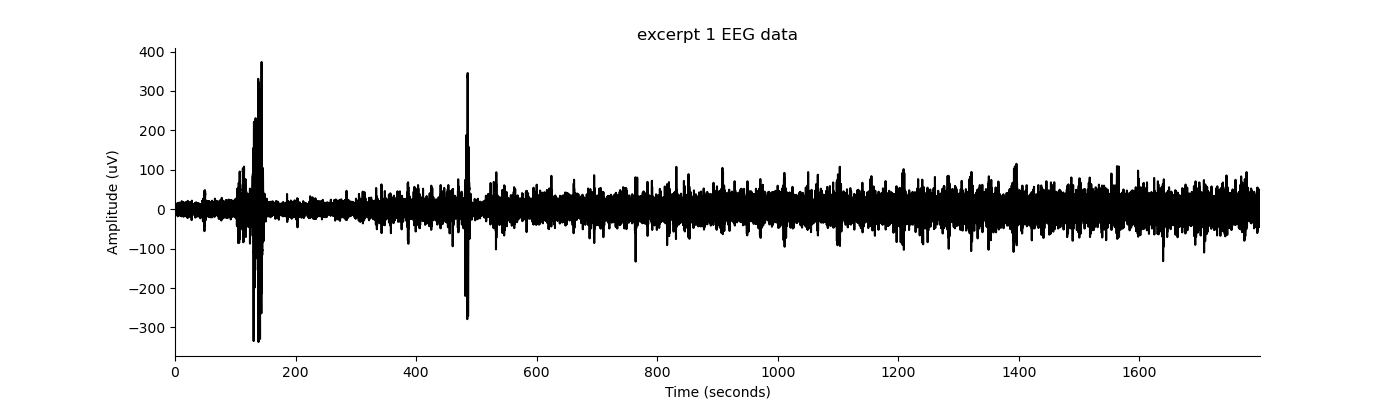

In [16]:
%matplotlib widget

# Define sampling frequency and time vector
sf = 200.
times = np.arange(excerpt_signals[0].size) / sf

# Plot the signal
fig, ax = plt.subplots(1, 1, figsize=(14, 4))
plt.plot(times, excerpt_signals[0], lw=1.5, color='k')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude (uV)')
plt.xlim([times.min(), times.max()])
plt.title('excerpt 1 EEG data')
sns.despine()

In [17]:
# Take the visual scoring for the first excerpt
visual_1 = df_visual.iloc[:,:2]
visual_1.dropna(inplace=True)
visual_1 = visual_1.values
visual_1.shape

(52, 2)

In [18]:
# create a boolean mask for the window of indices using np.zeros() and np.ones()
mask = np.zeros(excerpt_signals.shape[1], dtype=int)

for i in range(visual_1.shape[0]):
    start_index = int(visual_1[i][0]*sf)
    end_index = int(visual_1[i][0]*sf)+int(visual_1[i][1]*sf)
    mask[start_index:end_index] = 1

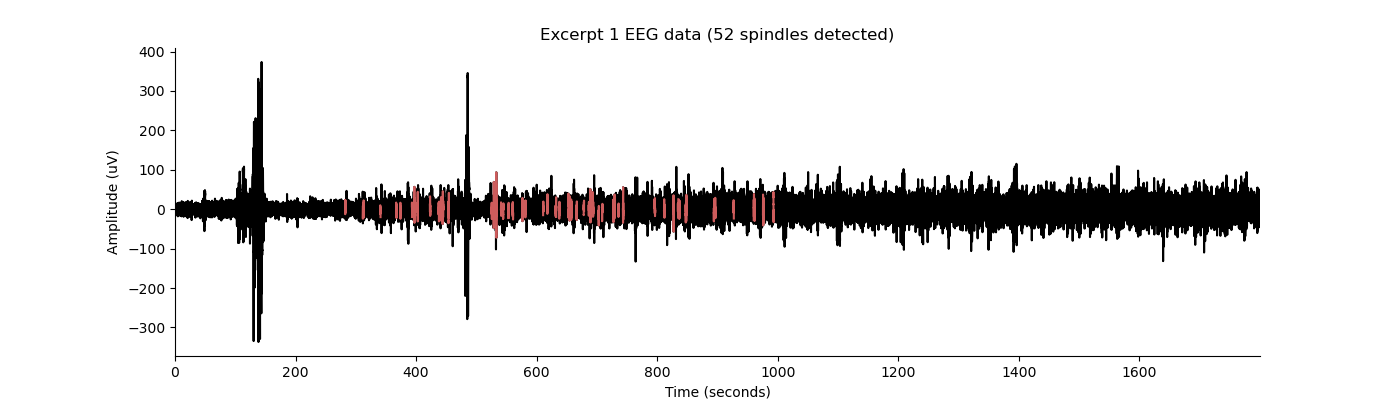

In [19]:
# Now let's plot
spindles_highlight = excerpt_signals[0] * mask
spindles_highlight[spindles_highlight == 0] = np.nan

plt.figure(figsize=(14, 4))
plt.plot(times, excerpt_signals[0], 'k')
plt.plot(times, spindles_highlight, 'indianred')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude (uV)')
plt.xlim([0, times[-1]])
plt.title('Excerpt 1 EEG data (52 spindles detected)')
sns.despine()
# plt.savefig('detection.png', dpi=300, bbox_inches='tight')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


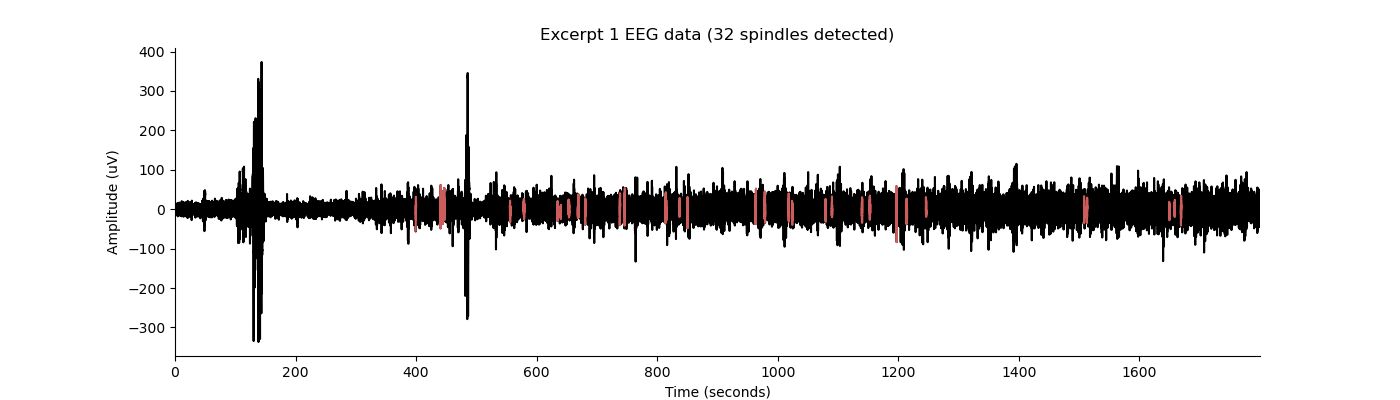

In [20]:
# Let's try to detect spindles using the YASA package and display the results
data = excerpt_signals[0]

sp = yasa.spindles_detect(data, sf)

# sp.summary()

mask = sp.get_mask()

# Now let's plot
spindles_highlight = data * mask
spindles_highlight[spindles_highlight == 0] = np.nan

plt.figure(figsize=(14, 4))
plt.plot(times, data, 'k')
plt.plot(times, spindles_highlight, 'indianred')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude (uV)')
plt.xlim([0, times[-1]])
plt.title(f'Excerpt 1 EEG data ({len(sp.summary())} spindles detected)')
sns.despine()

# Exctract features and labels

## Create masks for the visual spindles detection

In [21]:
# df_visual.iloc[:,:18].head(10)

In [22]:
df_visual_1 = df_visual.iloc[:,:16].copy()
df_visual_2 = df_visual.iloc[:,16:].copy()

In [23]:
# extract the spindeles position by the visual scoring of the first and second doctor
def spindles_positions(df_vis):
    spindles_positions = []
    # print(df_vis.shape)
    for i in range(0, df_vis.shape[1], 2):
        # print(df_vis.iloc[:,i-2:i])
        vis = df_vis.iloc[:,i:i+2]
        spindles_positions.append(vis.dropna().values)
    return spindles_positions

# visuals = []
# for i in range(0,16,2):
#     # print(df_visual.iloc[:,i-2:i])
#     vis = df_visual.iloc[:,i:i+2]
#     vis.dropna(inplace=True)
#     visuals.append(vis.values)
# len(visuals)
# [vis.shape for vis in visuals]
# type(visuals)


In [24]:
pos_1 = spindles_positions(df_visual_1)
pos_2 = spindles_positions(df_visual_2)
# [vis.shape for vis in pos_1]
# type(pos_1)


In [25]:
def create_mask(visual, sf, excerpt_signals):
    mask = np.zeros(excerpt_signals.shape[1], dtype=int)
    for i in range(visual.shape[0]):
        start_index = int(visual[i][0]*sf)
        end_index = int(visual[i][0]*sf)+int(visual[i][1]*sf)
        mask[start_index:end_index] = 1
    return mask

In [26]:
# masks = np.zeros(excerpt_signals.shape[0], dtype=int)
# masks = [create_mask(vis, sf, excerpt_signals) for vis in visuals]
# [m.sum() for m in masks]

In [27]:
masks_1 = np.zeros(excerpt_signals.shape[0], dtype=int)
masks_1 = [create_mask(vis, sf, excerpt_signals) for vis in pos_1]

masks_2 = np.zeros(excerpt_signals.shape[0], dtype=int)
masks_2 = [create_mask(vis, sf, excerpt_signals) for vis in pos_2]

# [m.sum() for m in masks_2]

## Features extraction

In [28]:
def extract_features(excerpt_signals, window_size=100, fs=200):
    # initialize an empty list to store the feature values
    feature_values = []

    # loop through each signal in excerpt_signals
    for i in range(excerpt_signals.shape[0]):
        signal = excerpt_signals[i, :]
        
        # calculate the total number of windows
        total_windows = signal.shape[0] // window_size

        # The second doctor did not score the last two excerpt, so we will ignore them
        if i == 6 or i == 7:
            v_mask_1 = masks_1[i]
            v_mask_2 = np.zeros(signal.shape[0], dtype=int)
        else:
            # extract the mask for the signal
            v_mask_1 = masks_1[i]
            v_mask_2 = masks_2[i]

        # use YASA to detect spindles
        sp = yasa.spindles_detect(data, sf)
        yasa_mask = sp.get_mask() if sp else np.zeros(signal.shape[0], dtype=int)

        # determine if a spindle occurs in the window using the masks of the two doctors and the YASA package
        spindles_visual_highlight_1 = signal * v_mask_1
        spindles_visual_highlight_2 = signal * v_mask_2
        spindles_visual_highlight_yasa = signal * yasa_mask
        
        # loop through each window in the signal
        for j in range(total_windows):
            # extract the window
            window = signal[j*window_size: (j+1)*window_size]
            
            if i == 6 or i == 7:
                spindle_in_window = 1 if (spindles_visual_highlight_1[j*window_size: (j+1)*window_size].sum()) > 0 else 0
            else:
                spindle_in_window = 1 if (np.array([spindles_visual_highlight_1[j*window_size: (j+1)*window_size].sum(), 
                                        spindles_visual_highlight_2[j*window_size: (j+1)*window_size].sum(), 
                                        spindles_visual_highlight_yasa[j*window_size: (j+1)*window_size].sum()]).sum()) >= 2 else 0
                
            # if spindle_in_window_v == 1:
            #     print(spindles_visual_highlight)
            #     print(spindle_in_window_v)

            # determine if a spindle occurs in the window using the YASA mask

            # spindle_in_window_yasa = 1 if (spindles_visual_highlight[j*window_size: (j+1)*window_size].sum()) > 1 else 0
            # if spindle_in_window_yasa == 1:
            #     print(spindles_visual_highlight)
            #     print(spindle_in_window_yasa)
            
            # compute sample entropy
            SpEn = nolds.sampen(window, emb_dim=2, tolerance=0.05*np.std(window))

            # compute maximum and minimum
            maximum = np.max(window)
            minimum = np.min(window)

            # compute variance and standard deviation
            variance = np.var(window)
            std_deviation = np.std(window)

            # compute phase amplitude coupling
            f, t, Sxx = spectrogram(window, fs=fs)
            PAC = np.sum(Sxx[11:17,:])/np.sum(Sxx)
        
            # compute instantaneous frequency
            inst_freq = np.mean(np.diff(np.unwrap(np.angle(hilbert(window)))))/(2*np.pi)

        
            # compute energy ratio (Energy11-16Hz)
            analytic_signal = hilbert(window)
            # calculate the amplitude of the analytic signal
            amplitude_envelope = np.abs(analytic_signal)
            # calculate the total energy of the input signal
            total_energy = np.sum(amplitude_envelope ** 2)
            # apply a bandpass filter to the amplitude envelope
            filtered_envelope = filter_signal(amplitude_envelope, 11, 16, fs, numtaps)
            # calculate the energy of the filtered signal
            spindle_energy = np.sum(filtered_envelope ** 2)
            energy_ratio = spindle_energy / total_energy
    
            # compute Power Spectral Density (PSD)
            f, Pxx = periodogram(window, fs=fs)

            # compute kurtosis and skewness
            kurt = kurtosis(Pxx)
            skewness = skew(Pxx)

            # compute power peak (PWRpeak)
            PWRpeak = np.max(Pxx)

            # compute power ratio (PWRratio)
            PWRratio = np.sum(Pxx[11:17])/np.sum(Pxx[:])

            # compute the empirical mode decomposition (EMD)
            decomposer = EMD()
            imfs = decomposer(window)
            # Extract the first mode from the IMFs
            mode_1 = imfs[0]
            
            # Compute the interquartile range (IQR) of the first mode
            q1, q3 = np.percentile(mode_1, [25, 75])
            IQR = q3 - q1

            # Compute zero crossing
            zero_crossing = len(np.where(np.diff(np.sign(mode_1)))[0])

            # Determine the patient id for future patient discimination
            patient_id = i+1
            
            # Append the computed feature values to the list
            feature_values.append([spindle_in_window, patient_id, SpEn, maximum, minimum, variance, std_deviation, PAC, inst_freq, energy_ratio,
                                   kurt, skewness, PWRpeak, PWRratio, IQR, zero_crossing])

    # create a pandas dataframe from the list of feature values
    feature_df = pd.DataFrame(feature_values, columns=['is_spindle', 'patient_id', 'SpEn', 'maximum', 'minimum', 'variance', 'std_deviation', 
                                                       'PAC', 'inst_freq', 'energy_ratio', 'kurt', 'skewness', 
                                                       'PWRpeak', 'PWRratio', 'IQR', 'zero_crossing'])

    return feature_df

In [29]:
df_features = extract_features(excerpt_signals)
df_features

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent work

,is_spindle,patient_id,SpEn,maximum,minimum,variance,std_deviation,PAC,inst_freq,energy_ratio,kurt,skewness,PWRpeak,PWRratio,IQR,zero_crossing
0,0,1,3.091042,-4.868705e-05,-7.753086e-03,3.454844e-06,1.858721e-03,0.004164,-0.001094,8.424509e-08,40.081961,6.329113,1.094418e-06,0.014988,5.618675e-04,31
1,0,1,inf,5.689756e-03,-5.422475e-03,7.894295e-06,2.809679e-03,0.012282,0.018894,2.443162e-07,34.898821,5.871523,2.217601e-06,0.013342,1.243414e-03,34
2,0,1,0.597227,7.481033e-02,2.823563e-03,4.841402e-04,2.200319e-02,0.000234,-0.000992,1.662477e-07,42.200411,6.536089,1.593872e-04,0.022406,1.622183e-03,35
3,0,1,1.791759,1.778605e-01,7.482668e-02,8.181524e-04,2.860336e-02,0.000660,-0.000665,8.798987e-08,38.475203,6.183382,2.402906e-04,0.020090,3.979508e-03,35
4,0,1,0.536305,1.818140e-01,-3.264030e-02,2.101107e-03,4.583784e-02,0.003454,-0.001320,1.426887e-07,40.517885,6.372533,5.949377e-04,0.051021,7.360702e-03,32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28795,0,8,inf,3.262406e+07,-3.106363e+07,1.726147e+14,1.313829e+07,0.132083,0.028943,1.405083e-07,24.574508,4.711566,2.967296e+13,0.121649,9.282704e+06,23
28796,0,8,inf,3.861549e+07,-4.488254e+07,2.795103e+14,1.671856e+07,0.338078,0.068598,2.877931e-07,22.810372,4.709992,5.070959e+13,0.295904,1.558419e+07,29
28797,0,8,1.540445,3.992002e+07,-7.780565e+07,7.262763e+14,2.694951e+07,0.062039,0.009110,1.723961e-07,45.474088,6.870142,2.842681e+14,0.069864,1.444600e+07,30
28798,0,8,1.609438,7.368973e+07,3.103479e+06,2.761549e+14,1.661791e+07,0.153932,-0.000339,1.114966e-07,19.799863,4.143766,4.175819e+13,0.192646,1.541441e+07,23


In [30]:
df_features.is_spindle.sum()

1116

In [31]:
# Count infinite values in SpEn feature
print('infinites in SpEn:', df_features.SpEn.loc[df_features['SpEn'] == np.inf].count())

infinites in SpEn: 1336


In [32]:
# Get the maximum value besides infinite in SpEn
print('Get maximum value besides SpEn:', df_features.SpEn.loc[df_features['SpEn'] != np.inf].max())

Get maximum value besides SpEn: 3.1780538303479458


In [33]:
# Cap the infinites to the maximum values besides it
df_features.loc[df_features['SpEn'] == np.inf, 'SpEn'] = df_features.SpEn.loc[df_features['SpEn'] != np.inf].max()

In [34]:
# Check for null values created by mistake
df_features.isna().sum()

is_spindle       0
patient_id       0
SpEn             0
maximum          0
minimum          0
variance         0
std_deviation    0
PAC              0
inst_freq        0
energy_ratio     0
kurt             0
skewness         0
PWRpeak          0
PWRratio         0
IQR              0
zero_crossing    0
dtype: int64

# Train-test split

Put the samples from the first 5 samples into the train set and the samples from the last 8 patients in the test set

In [35]:
# Check the number of spindles for each patient in the dataset
for i in range(8):
    print('Patient', i+1)
    print('Number of samples:', df_features.loc[df_features['patient_id'] == i+1].shape[0])
    temp = df_features.loc[df_features['patient_id'] == i+1]
    num_spindles = temp['is_spindle'].sum()
    print('Number of spindles:', num_spindles)
    print('-'*20)


Patient 1
Number of samples: 3600
Number of spindles: 236
--------------------
Patient 2
Number of samples: 3600
Number of spindles: 144
--------------------
Patient 3
Number of samples: 3600
Number of spindles: 110
--------------------
Patient 4
Number of samples: 3600
Number of spindles: 126
--------------------
Patient 5
Number of samples: 3600
Number of spindles: 195
--------------------
Patient 6
Number of samples: 3600
Number of spindles: 219
--------------------
Patient 7
Number of samples: 3600
Number of spindles: 24
--------------------
Patient 8
Number of samples: 3600
Number of spindles: 62
--------------------


In [36]:
# We want 70% of spindles in the training set and 30% of the spindles in the testing set
print('Total number of spindles:', df_features[df_features['is_spindle'] == 1].shape[0])
print('Number of spindles to have 70% of the spindles:', int(df_features[df_features['is_spindle'] == 1].shape[0]*0.7))
print('Number of spindles to have 30% of the spindles:', int(df_features[df_features['is_spindle'] == 1].shape[0]*0.3))

Total number of spindles: 1116
Number of spindles to have 70% of the spindles: 781
Number of spindles to have 30% of the spindles: 334


In [37]:
# Get ~70% of the spindles by taking patients 1, 2, 4, 6, 8 in the training set
df_train = df_features[df_features['patient_id'].isin([1, 2, 4, 6, 8])]
df_train

,is_spindle,patient_id,SpEn,maximum,minimum,variance,std_deviation,PAC,inst_freq,energy_ratio,kurt,skewness,PWRpeak,PWRratio,IQR,zero_crossing
0,0,1,3.091042,-4.868705e-05,-7.753086e-03,3.454844e-06,1.858721e-03,0.004164,-0.001094,8.424509e-08,40.081961,6.329113,1.094418e-06,0.014988,5.618675e-04,31
1,0,1,3.178054,5.689756e-03,-5.422475e-03,7.894295e-06,2.809679e-03,0.012282,0.018894,2.443162e-07,34.898821,5.871523,2.217601e-06,0.013342,1.243414e-03,34
2,0,1,0.597227,7.481033e-02,2.823563e-03,4.841402e-04,2.200319e-02,0.000234,-0.000992,1.662477e-07,42.200411,6.536089,1.593872e-04,0.022406,1.622183e-03,35
3,0,1,1.791759,1.778605e-01,7.482668e-02,8.181524e-04,2.860336e-02,0.000660,-0.000665,8.798987e-08,38.475203,6.183382,2.402906e-04,0.020090,3.979508e-03,35
4,0,1,0.536305,1.818140e-01,-3.264030e-02,2.101107e-03,4.583784e-02,0.003454,-0.001320,1.426887e-07,40.517885,6.372533,5.949377e-04,0.051021,7.360702e-03,32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28795,0,8,3.178054,3.262406e+07,-3.106363e+07,1.726147e+14,1.313829e+07,0.132083,0.028943,1.405083e-07,24.574508,4.711566,2.967296e+13,0.121649,9.282704e+06,23
28796,0,8,3.178054,3.861549e+07,-4.488254e+07,2.795103e+14,1.671856e+07,0.338078,0.068598,2.877931e-07,22.810372,4.709992,5.070959e+13,0.295904,1.558419e+07,29
28797,0,8,1.540445,3.992002e+07,-7.780565e+07,7.262763e+14,2.694951e+07,0.062039,0.009110,1.723961e-07,45.474088,6.870142,2.842681e+14,0.069864,1.444600e+07,30
28798,0,8,1.609438,7.368973e+07,3.103479e+06,2.761549e+14,1.661791e+07,0.153932,-0.000339,1.114966e-07,19.799863,4.143766,4.175819e+13,0.192646,1.541441e+07,23


In [38]:
# Get ~30% of the spindles by taking patients 3, 5, 7 in the training set
df_test = df_features[df_features['patient_id'].isin([3, 5, 7])]
df_test

,is_spindle,patient_id,SpEn,maximum,minimum,variance,std_deviation,PAC,inst_freq,energy_ratio,kurt,skewness,PWRpeak,PWRratio,IQR,zero_crossing
7200,0,3,2.397895,1.183822e-02,5.693564e-04,7.891607e-06,2.809200e-03,0.015571,-0.001185,7.683931e-08,22.282956,4.554082,1.486310e-06,0.012765,1.065316e-03,35
7201,0,3,2.079442,9.449746e-03,-4.571577e-02,2.337958e-04,1.529038e-02,0.002090,0.029086,2.204172e-07,42.001297,6.512952,7.394488e-05,0.013508,3.696097e-03,35
7202,0,3,3.178054,-3.793065e-02,-1.144225e-01,4.796965e-04,2.190197e-02,0.003858,-0.000442,8.371957e-08,43.660738,6.683122,1.670682e-04,0.031397,1.050633e-02,35
7203,0,3,2.014903,5.268750e-02,-1.094077e-01,1.564606e-03,3.955509e-02,0.010331,0.019347,1.680890e-07,34.843169,5.810267,3.875944e-04,0.054637,2.666889e-02,35
7204,0,3,1.760988,4.375647e+00,-4.807616e-01,2.237357e-01,4.730071e-01,0.050692,0.007915,1.924832e-07,7.134842,2.642795,9.993578e-03,0.109495,9.189734e-02,35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25195,0,7,2.014903,2.821515e+07,-2.082030e+07,1.023583e+14,1.011723e+07,0.021020,0.039589,2.970076e-07,6.634840,2.765525,1.127302e+13,0.015162,3.436537e+06,26
25196,0,7,1.897120,2.842495e+07,-2.708895e+07,1.701157e+14,1.304284e+07,0.012581,0.009692,2.199804e-07,39.968874,6.305678,5.309307e+13,0.011833,6.861758e+06,16
25197,0,7,2.079442,5.523464e+06,-4.069012e+07,1.511549e+14,1.229451e+07,0.030019,0.018378,8.838717e-08,34.471969,5.762233,3.951998e+13,0.043167,1.022889e+07,17
25198,0,7,0.815037,5.473693e+07,-5.978502e+07,5.362476e+14,2.315702e+07,0.008341,0.008758,6.511686e-08,44.065664,6.729093,2.084759e+14,0.010823,4.798240e+06,22


The dataset is now splitted into train and test sets, but these sets are unbalanced

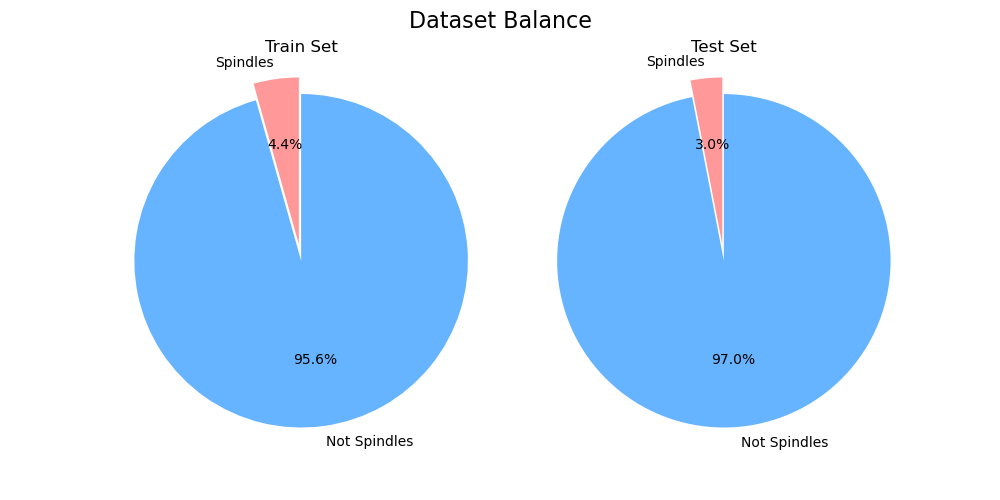

In [39]:
# Calculate the counts for train set
train_positive_count = df_train['is_spindle'].sum()
train_negative_count = len(df_train) - train_positive_count

# Calculate the counts for test set
test_positive_count = df_test['is_spindle'].sum()
test_negative_count = len(df_test) - test_positive_count

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Train set pie chart
train_labels = ['Spindles', 'Not Spindles']
train_sizes = [train_positive_count, train_negative_count]
train_colors = ['#ff9999', '#66b3ff']
train_explode = (0.1, 0)

ax1.pie(train_sizes, labels=train_labels, colors=train_colors, explode=train_explode,
        autopct='%1.1f%%', startangle=90)
ax1.set_title('Train Set')

# Test set pie chart
test_labels = ['Spindles', 'Not Spindles']
test_sizes = [test_positive_count, test_negative_count]
test_colors = ['#ff9999', '#66b3ff']
test_explode = (0.1, 0)

ax2.pie(test_sizes, labels=test_labels, colors=test_colors, explode=test_explode,
        autopct='%1.1f%%', startangle=90)
ax2.set_title('Test Set')

ax1.axis('equal')
ax2.axis('equal')
fig.suptitle('Dataset Balance', fontsize=16)

plt.show()

## Not augmented dataset

Solve the unbalanced situation of the train set:

Here we just cut out non-spindle samples to reach a balancing of 50% spindle and 50% not spindle classes.

Below we also implement an augmentation technique to add synthetic data for the spindles.

In [40]:
df_train

,is_spindle,patient_id,SpEn,maximum,minimum,variance,std_deviation,PAC,inst_freq,energy_ratio,kurt,skewness,PWRpeak,PWRratio,IQR,zero_crossing
0,0,1,3.091042,-4.868705e-05,-7.753086e-03,3.454844e-06,1.858721e-03,0.004164,-0.001094,8.424509e-08,40.081961,6.329113,1.094418e-06,0.014988,5.618675e-04,31
1,0,1,3.178054,5.689756e-03,-5.422475e-03,7.894295e-06,2.809679e-03,0.012282,0.018894,2.443162e-07,34.898821,5.871523,2.217601e-06,0.013342,1.243414e-03,34
2,0,1,0.597227,7.481033e-02,2.823563e-03,4.841402e-04,2.200319e-02,0.000234,-0.000992,1.662477e-07,42.200411,6.536089,1.593872e-04,0.022406,1.622183e-03,35
3,0,1,1.791759,1.778605e-01,7.482668e-02,8.181524e-04,2.860336e-02,0.000660,-0.000665,8.798987e-08,38.475203,6.183382,2.402906e-04,0.020090,3.979508e-03,35
4,0,1,0.536305,1.818140e-01,-3.264030e-02,2.101107e-03,4.583784e-02,0.003454,-0.001320,1.426887e-07,40.517885,6.372533,5.949377e-04,0.051021,7.360702e-03,32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28795,0,8,3.178054,3.262406e+07,-3.106363e+07,1.726147e+14,1.313829e+07,0.132083,0.028943,1.405083e-07,24.574508,4.711566,2.967296e+13,0.121649,9.282704e+06,23
28796,0,8,3.178054,3.861549e+07,-4.488254e+07,2.795103e+14,1.671856e+07,0.338078,0.068598,2.877931e-07,22.810372,4.709992,5.070959e+13,0.295904,1.558419e+07,29
28797,0,8,1.540445,3.992002e+07,-7.780565e+07,7.262763e+14,2.694951e+07,0.062039,0.009110,1.723961e-07,45.474088,6.870142,2.842681e+14,0.069864,1.444600e+07,30
28798,0,8,1.609438,7.368973e+07,3.103479e+06,2.761549e+14,1.661791e+07,0.153932,-0.000339,1.114966e-07,19.799863,4.143766,4.175819e+13,0.192646,1.541441e+07,23


In [41]:
# Calculate the target number of samples for each class based on the desired balance
target_sample_count_train = len(df_train) // 2
target_sample_count_test = len(df_test) // 2

# Filter spindle and non-spindle samples separately
spindle_samples_train = df_train[df_train['is_spindle'] == 1]
non_spindle_samples_train = df_train[df_train['is_spindle'] == 0]
spindle_samples_test = df_test[df_test['is_spindle'] == 1]
non_spindle_samples_test = df_test[df_test['is_spindle'] == 0]

# Randomly sample from non-spindle samples to achieve the desired balance in the train set
if len(non_spindle_samples_train) > target_sample_count_train:
    non_spindle_samples_train = non_spindle_samples_train.sample(n=target_sample_count_train, random_state=42)

# Randomly sample from non-spindle samples to achieve the desired balance in the test set
if len(non_spindle_samples_test) > target_sample_count_test:
    non_spindle_samples_test = non_spindle_samples_test.sample(n=target_sample_count_test, random_state=42)

# Concatenate the balanced samples for the train and test sets
df_train_balanced = pd.concat([spindle_samples_train, non_spindle_samples_train])
df_test_balanced = pd.concat([spindle_samples_test, non_spindle_samples_test])

# Shuffle the balanced dataframes
df_train_bal = df_train_balanced.sample(frac=1, random_state=42).reset_index(drop=True)
df_test_bal = df_test_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

In [42]:
# Check number of samples in the training set after balancing
print('Number of samples after balancing the train set:', df_train_bal.shape[0])
print(df_train_bal.head(3))

Number of samples after balancing the train set: 9787
   is_spindle  patient_id      SpEn    maximum    minimum    variance   
0           0           2  1.139434  12.295379 -25.768326   87.988109  \
1           0           1  0.676887  15.830048 -59.082590  557.761580   
2           0           1  0.619039  46.109792 -26.085600  318.037945   

   std_deviation       PAC  inst_freq  energy_ratio       kurt  skewness   
0       9.380198  0.018777   0.019114  3.670170e-07  15.239761  3.938654  \
1      23.616977  0.001634   0.019316  1.288335e-07  45.520761  6.876165   
2      17.833618  0.002365   0.018528  1.162013e-07  41.177917  6.446457   

      PWRpeak  PWRratio        IQR  zero_crossing  
0   14.837926  0.023830   3.035498             19  
1  241.793064  0.004059   4.810575             16  
2  108.047171  0.014649  10.708809             14  


In [43]:
# Check number of samples in the testing set after balancing
print('Number of samples after balancing the train set:', df_test_bal.shape[0])
print(df_test_bal.head(3))

Number of samples after balancing the train set: 5729
   is_spindle  patient_id      SpEn       maximum       minimum      variance   
0           0           5  0.733969  2.608016e+07 -3.373043e+07  2.606649e+14  \
1           0           7  1.145132  3.439681e+07 -2.169366e+07  2.567266e+14   
2           0           7  1.178655  6.460570e+07 -3.850077e+07  5.396730e+14   

   std_deviation       PAC  inst_freq  energy_ratio       kurt  skewness   
0   1.614512e+07  0.003003   0.019119  2.935727e-07  19.516327  4.493523  \
1   1.602269e+07  0.011261   0.009401  9.536272e-08  39.610349  6.301236   
2   2.323086e+07  0.005251   0.020679  9.860056e-08  33.409775  5.679399   

        PWRpeak  PWRratio           IQR  zero_crossing  
0  5.494654e+13  0.010401  5.583821e+06             15  
1  8.788176e+13  0.013183  4.315760e+06             21  
2  1.467648e+14  0.004196  1.207822e+07             16  


Now the datasets are balanced, although we excluded many samples and we don't have that many from our data, so we'll test out also some data augmentation techniques later.

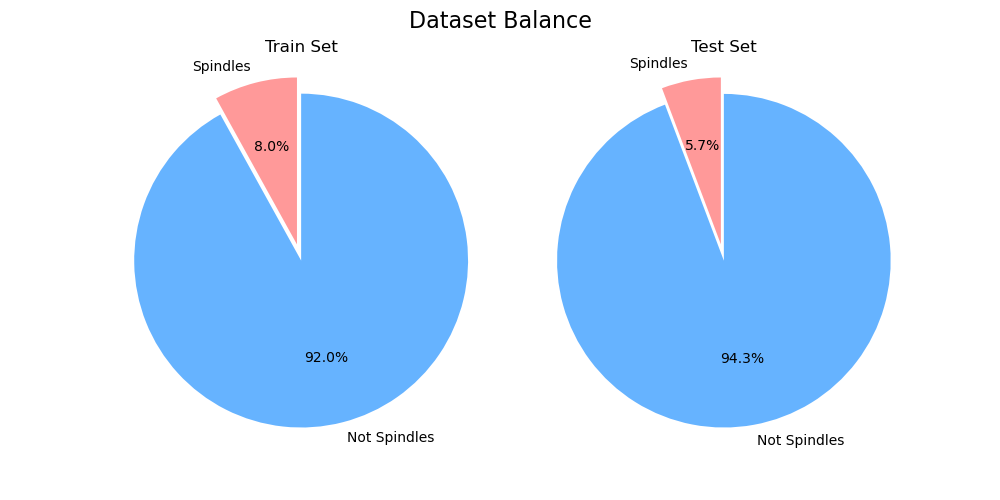

In [44]:
# Calculate the counts for train set
train_positive_count = df_train_bal['is_spindle'].sum()
train_negative_count = len(df_train_bal) - train_positive_count

# Calculate the counts for test set
test_positive_count = df_test_bal['is_spindle'].sum()
test_negative_count = len(df_test_bal) - test_positive_count

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Train set pie chart
train_labels = ['Spindles', 'Not Spindles']
train_sizes = [train_positive_count, train_negative_count]
train_colors = ['#ff9999', '#66b3ff']
train_explode = (0.1, 0)

ax1.pie(train_sizes, labels=train_labels, colors=train_colors, explode=train_explode,
        autopct='%1.1f%%', startangle=90)
ax1.set_title('Train Set')

# Test set pie chart
test_labels = ['Spindles', 'Not Spindles']
test_sizes = [test_positive_count, test_negative_count]
test_colors = ['#ff9999', '#66b3ff']
test_explode = (0.1, 0)

ax2.pie(test_sizes, labels=test_labels, colors=test_colors, explode=test_explode,
        autopct='%1.1f%%', startangle=90)
ax2.set_title('Test Set')

ax1.axis('equal')
ax2.axis('equal')
fig.suptitle('Dataset Balance', fontsize=16)

plt.show()

## Augmented Dataset

Here we implement an augmentation technique to add synthetic data for the spindles.

We'll test out different algorithms for the data augmentation: SMOTE, ...

In [45]:
def smote_transform(train: pd.DataFrame, target: str):
    df = train.copy()

    # We split the target and the rest of the features
    y = df[target]
    x = df.drop([target], axis=1)

    # Defining our over-sampler and under-sampler
    over = SMOTE(sampling_strategy='auto', random_state=42, n_jobs=-1)

    # Transform the dataset
    x, y = over.fit_resample(x, y)

    # merge the target feature with the rest of the features
    df = pd.DataFrame(pd.concat([x, y], axis=1))

    return df

# Modelling

In [ ]:
target = 'is_spindle'

# Splitting the data:
x_train, x_test, y_train, y_test = train_test_split(df_features.drop(target, axis=1),
                                                        df_features[target],
                                                        test_size=0.33,
                                                        random_state=42)

In [ ]:
# function to evaluate the model

def evaluate_model(y_true, y_pred):    
    # Convert continuous targets to binary targets using a threshold of 0.5
    y_true_binary = (y_true > 0.5).astype(int)
    y_pred_binary = (y_pred > 0.5).astype(int)

    # Calculate evaluation metrics on binary targets
    accuracy = accuracy_score(y_true_binary, y_pred_binary)
    precision = precision_score(y_true_binary, y_pred_binary)
    recall = recall_score(y_true_binary, y_pred_binary)
    f1 = f1_score(y_true_binary, y_pred_binary)
    roc_auc = roc_auc_score(y_true, y_pred)
    conf_mat = confusion_matrix(y_true_binary, y_pred_binary)


    # Create a list of metric names and values
    metrics = ["Accuracy", "Precision", "Recall", "F1 Score", "ROC AUC"]
    values = [accuracy, precision, recall, f1, roc_auc]

    # Create a list of lists for tabulating
    table = [metrics, values]

    # Display the table
    print(tabulate(table, headers='firstrow'))


    # Create a heatmap of the confusion matrix
    sns.heatmap(conf_mat, annot=True, cmap='Blues', fmt='g', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])

    # Add labels and title
    plt.xlabel('Prediction')
    plt.ylabel('Truth')
    plt.title('Confusion Matrix')

    # Show the plot
    plt.show()

In [ ]:
from sklearn.svm import SVC

model = SVC(random_state=42)

model.fit(x_train, y_train)

SVC(random_state=42)

In [ ]:
pred = model.predict(x_test)

  Accuracy    Precision    Recall    F1 Score    ROC AUC
----------  -----------  --------  ----------  ---------
  0.962647            0         0           0        0.5


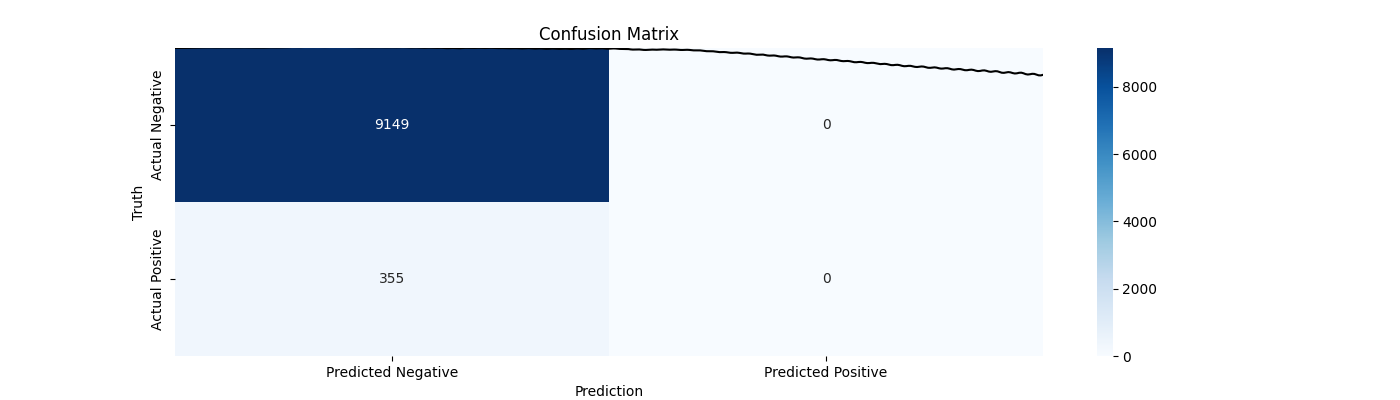

In [ ]:
evaluate_model(y_test, pred)

In [ ]:
# from __future__ import annotations
# import pandas as pd
# # Modelling:
# from hyperopt import hp, Trials, fmin, STATUS_OK, tpe
# from sklearn.metrics import f1_score, make_scorer
# from sklearn.model_selection import cross_val_score, StratifiedKFold


# def objective(space, x_train: pd.DataFrame, y_train: pd.DataFrame, x_test: pd.DataFrame, y_test: pd.DataFrame,
#               cross_validation: int = 5, fast: bool = False):

#     model = SVC(C=space['C'],
#                 kernel=space['kernel'],
#                 degree=space['degree'],
#                 gamma=space['gamma'],
#                 random_state=42)

#     # define the model evaluation data
#     X = pd.concat([x_train, x_test])
#     y = pd.concat([y_train, y_test])

#     # since we have an imbalanced dataset, we need to use stratified k-fold cross-validation:
#     cv = StratifiedKFold(n_splits=cross_validation, shuffle=True, random_state=42)

#     if fast:
#         cv = 2

#     # since we are interested in churners, the positive class, the f1 is a good metric:
#     metric = make_scorer(f1_score)

#     # evaluate the model:
#     f1 = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1).mean()

#     # return the loss, 1 - f1 score since we want to maximize the f1 score:
#     return {'loss': 1 - f1, 'status': STATUS_OK}


# def tuner(x_train: pd.DataFrame, y_train: pd.DataFrame,
#           x_test: pd.DataFrame, y_test: pd.DataFrame, max_evaluations: int = 100,
#           cross_validation: int = 5, fast: bool = False):

#     # define the search space, choose the parameters to tune:
#     space = {
#         'C': hp.uniform('C', 0.1, 1),
#         'kernel': hp.choice('kernel', ['linear', 'rbf', 'sigmoid', 'poly']),
#         'degree': hp.choice('degree', [2, 3, 4, 5, 6]),
#     }

#     # define the trials object:
#     trials = Trials()

#     # run the optimization:
#     best = fmin(fn=lambda search_space: objective(search_space, x_train, y_train, x_test, y_test,
#                                                   cross_validation, fast),
#                 space=space, algo=tpe.suggest, max_evals=max_evaluations, trials=trials)

#     # filter out the parameters that are 0:
#     best = {k: v for k, v in best.items() if v != 0}

#     return best

# # tune the model:
# best = tuner(x_train, y_train, x_test, y_test, max_evaluations=100, cross_validation=5, fast=False)
# print(best)

# # train the model with the best parameters:
# model = SVC(**best, random_state=42)
# model.fit(x_train, y_train)

# # train the model:
# model.fit(x_train, y_train)

# # evaluate the model:
# y_pred = model.predict(x_test)
# print(f1_score(y_test, y_pred))